In [1]:
import math
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import skimage.transform as sktr
import skimage.color as color
import skimage.io as skio
import scipy.misc
from scipy import signal
import scipy
plt.rcParams['image.cmap'] = 'gray'
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Part 0: Warmup

## Functions

In [2]:
def gaussian_filter(img, sigma):
    w = 100
    h = 100
    x, y = np.mgrid[round(-w/2):round(w/2), round(-h/2):round(h/2)]
    f = np.exp(-x**2/(2*sigma**2)-y**2/(2*sigma**2))
    gaussian = f/f.sum()
    gaus = signal.fftconvolve(img, gaussian, mode='same')
    return gaus
    

## Main

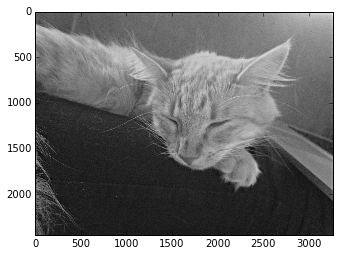

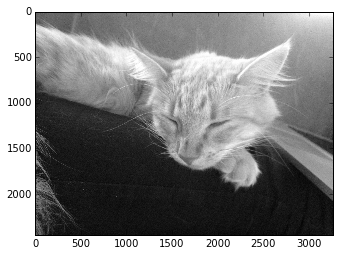

In [16]:
#import image
fimg = plt.imread('cat.jpg')/255.
img = color.rgb2gray(fimg) 

sigma = 40
# blur = scipy.ndimage.filters.gaussian_filter(img,25) 

#convolve with gaussian
blur = gaussian_filter(img, sigma)

#create the sharppend image
unsharp = img + 0.4*(img-blur)

plt.figure()
plt.imshow(unsharp)
plt.show
plt.figure()
plt.imshow(img)
plt.show
scipy.misc.toimage(img-blur).save('high.jpg')
scipy.misc.toimage(blur).save('blur.jpg')
scipy.misc.toimage(img).save('original.jpg')
scipy.misc.toimage(unsharp).save('sharpened.jpg')

# Part 1: Hybrid Images

## Functions

In [4]:
def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = int(np.abs(2*r+1 - R))
    cpad = int(np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

In [5]:
def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

In [6]:
def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[np.floor((h2-h1)/2.) : -np.ceil((h2-h1)/2.), :, :]
    elif h1 > h2:
        im1 = im1[np.floor((h1-h2)/2.) : -np.ceil((h1-h2)/2.), :, :]
    if w1 < w2:
        im2 = im2[:, np.floor((w2-w1)/2.) : -np.ceil((w2-w1)/2.), :]
    elif w1 > w2:
        im1 = im1[:, np.floor((w1-w2)/2.) : -np.ceil((w1-w2)/2.), :]
    assert im1.shape == im2.shape
    return im1, im2

In [7]:
def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

In [8]:
def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, dscale)
    else:
        im2 = sktr.rescale(im2, 1./dscale)
    return im1, im2

In [9]:
def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape
    
    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

In [10]:
def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

In [11]:
def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2

In [12]:
def hybrid_image(im1, im2, sigma1, sigma2):
    im1 = color.rgb2gray(im1)
    im2 = color.rgb2gray(im2)
    high = im1-gaussian_filter(im1,sigma1)
    low = gaussian_filter(im2,sigma2)
    scipy.misc.toimage(low).save('lowf.jpg')
    scipy.misc.toimage(high).save('highf.jpg')
    return (low+high), low, high

## Main

In [13]:
# First load images

# high sf
im1 = plt.imread('tj.jpg')/255.
im1g = color.rgb2gray(im1)

# low sf
im2 = plt.imread('me.jpg')/255.
im2g = color.rgb2gray(im2)

scipy.misc.toimage(im1g).save('im1.jpg')
scipy.misc.toimage(im2g).save('im2.jpg')
%pylab qt
# Next align images (this code is provided, but may be improved)
im1_aligned, im2_aligned = align_images(im1, im2)

%pylab inline

/Users/Annalise/anaconda/lib/python2.7/site-packages/matplotlib/backend_bases.py:2399: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)
/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Populating the interactive namespace from numpy and matplotlib
Please select 2 points in each image for alignment.
Populating the interactive namespace from numpy and matplotlib


/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


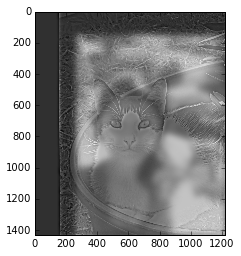

In [14]:
## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies

sigma1 = 10
sigma2 = 20
hybrid, low, high = hybrid_image(im1_aligned, im2_aligned, sigma1, sigma2)

plt.imshow(hybrid)
plt.show
scipy.misc.toimage(hybrid).save('hybrid.jpg')

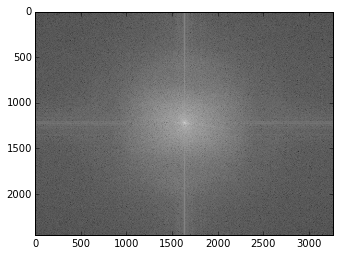

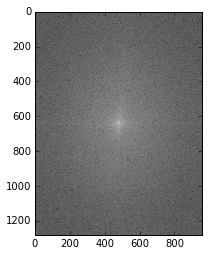

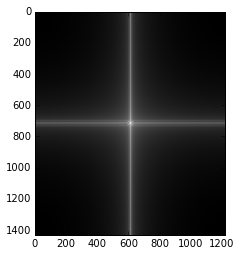

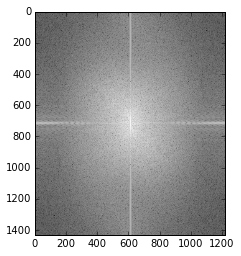

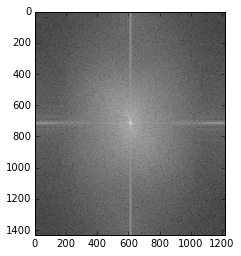

In [15]:
## FFT images
ffim1g = np.log(np.abs(np.fft.fftshift(np.fft.fft2(im1g))))
ffim2g = np.log(np.abs(np.fft.fftshift(np.fft.fft2(im2g))))
fflow = np.log(np.abs(np.fft.fftshift(np.fft.fft2(low))))
ffhigh = np.log(np.abs(np.fft.fftshift(np.fft.fft2(high))))
ffhybrid = np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid))))
plt.figure()
plt.imshow(ffim1g)
plt.figure()
plt.imshow(ffim2g)
plt.figure()
plt.imshow(fflow)
plt.figure()
plt.imshow(ffhigh)
plt.figure()
plt.imshow(ffhybrid)
plt.show()
scipy.misc.toimage(ffim1g).save('ffim1.jpg')
scipy.misc.toimage(ffim2g).save('ffim2.jpg')
scipy.misc.toimage(fflow).save('fflow.jpg')
scipy.misc.toimage(ffhigh).save('ffhigh.jpg')
scipy.misc.toimage(ffhybrid).save('ffhybrid.jpg')

# Part 2: Gaussian and Laplacian Stacks

## Functions

In [17]:
def gStack(iimg, N):
    w, h = iimg.shape
    stack = numpy.zeros((w,h,N))
    for x in range(0,N):
        sigma = 2**x
        img = gaussian_filter(iimg,sigma)
        stack[:,:,x] = img
    return stack

In [18]:
def lStack(gstack):
    w,h,n = gstack.shape
    stack = numpy.zeros((w,h,n))
    for x in range(0,n-1):
        img = gstack[:,:,x]-gstack[:,:,x+1]
        stack[:,:,x] = img
        if x == n-2:
            stack[:,:,x+1] = gstack[:,:,x+1]
    return stack

## Main

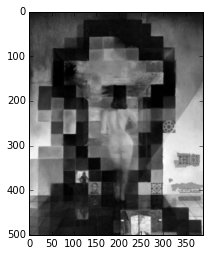

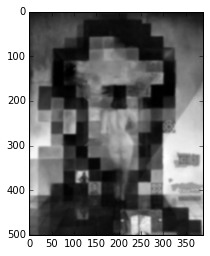

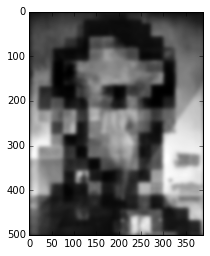

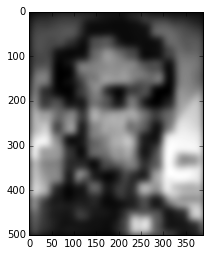

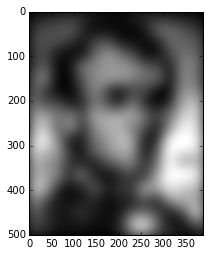

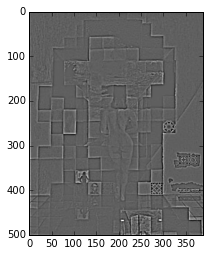

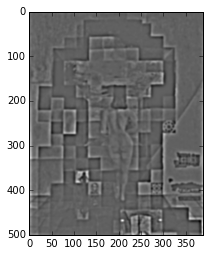

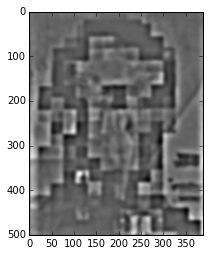

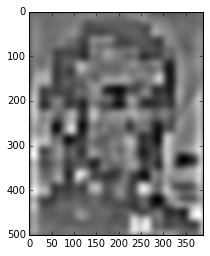

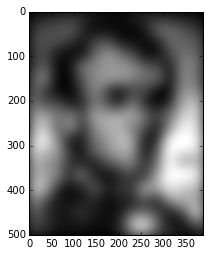

In [19]:
## Compute and display Gaussian and Laplacian Pyramids
## You also need to supply this function
N = 5 # suggested number of pyramid levels (your choice)
## Load in image
him = plt.imread('lincoln.jpg')/255.
himg = color.rgb2gray(him)
gstack = gStack(himg, N)
lstack = lStack(gstack)
for x in range(0,N):
    plt.figure()
    string = "gstack"+str(x)+".jpg"
    scipy.misc.toimage(gstack[:,:,x]).save(string)
    plt.imshow(gstack[:,:,x])
    plt.show()
for x in range(0,N):
    plt.figure()
    string = "lstack"+str(x)+".jpg"
    scipy.misc.toimage(lstack[:,:,x]).save(string)
    plt.imshow(lstack[:,:,x])
    plt.show()   

# Part 3: Multiresolution Blending

## Functions

In [20]:
def alphagStack(iimg, N, alpha):
    w, h = iimg.shape
    stack = numpy.zeros((w,h,N))
    for x in range(0,N):
        sigma = (2**(x*alpha))
        img = gaussian_filter(iimg,sigma)
        stack[:,:,x] = img
    return stack

In [21]:
def blend(left_lstack,right_lstack,left_gstack,right_gstack,mask_gstack,N): 
    w, h, N = mask_gstack.shape
    blend = numpy.zeros((w,h))
    aleft = numpy.zeros((w,h))
    aright = numpy.zeros((w,h))
    for x in range(0,N):
        left = mask_gstack[:,:,x]*left_lstack[:,:,x]
        right = (1 - mask_gstack[:,:,x])*right_lstack[:,:,x]
        blend += left + right
        aleft += left
        aright += right
        plt.figure()
        plt.imshow(left)
        string = "left"+str(x)+".jpg"
        scipy.misc.toimage(left).save(string)
        plt.figure()
        plt.imshow(right)
        string = "right"+str(x)+".jpg"
        scipy.misc.toimage(right).save(string)
        plt.figure()
        plt.imshow(left+right)
        string = "mix"+str(x)+".jpg"
        scipy.misc.toimage(left+right).save(string)
        plt.show()
    return blend,aleft,aright

## Main

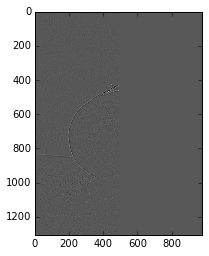

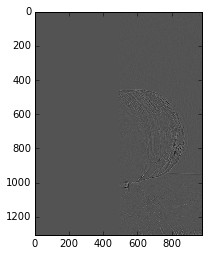

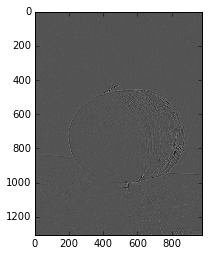

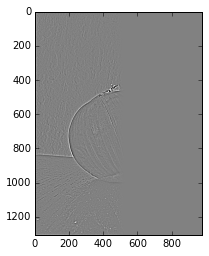

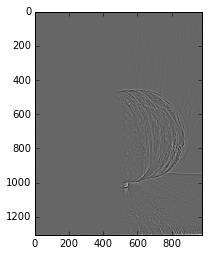

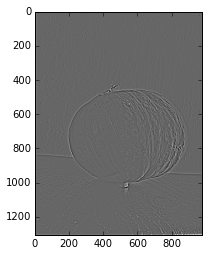

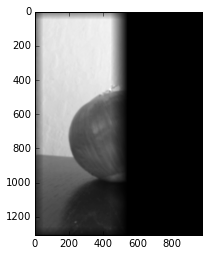

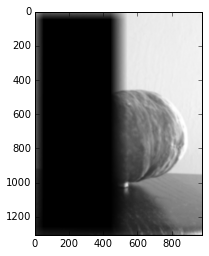

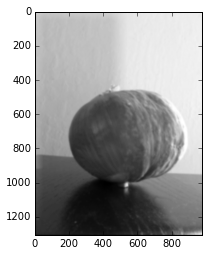

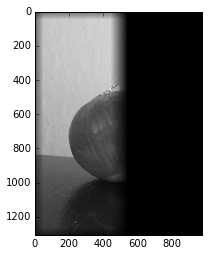

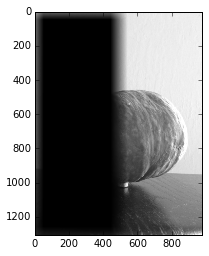

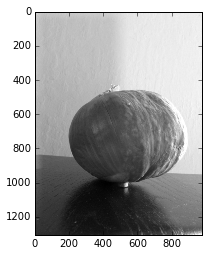

In [23]:
# Set N for number of layers and alpha
N = 3
alpha = 4

# Read in images and mask, creat Gaussian and Laplacian Stacks
left = plt.imread('oni.jpg')/255.
left = sktr.rescale(left, 0.4)
leftg = color.rgb2gray(left)
left_gstack = gStack(leftg, N)
left_lstack = lStack(left_gstack)

right = plt.imread('pump.jpg')/255.
right = sktr.rescale(right, 0.4)
rightg = color.rgb2gray(right)
right_gstack = gStack(rightg, N)
right_lstack = lStack(right_gstack)

mask = plt.imread('mask.jpg')/255.
mask = sktr.resize(mask, left.shape)
maskg = color.rgb2gray(mask)
mask_gstack = alphagStack(maskg, N, alpha)

# for x in range(0,N):
#     plt.figure()
#     plt.imshow(mask_gstack[:,:,x])
#     plt.show()
    
# Blend images
bimg,aleft,aright = blend(left_lstack,right_lstack,left_gstack,right_gstack,mask_gstack,N)
plt.imshow(aleft)
string = "aleft"+".jpg"
scipy.misc.toimage(aleft).save(string)
plt.figure()
plt.imshow(aright)
string = "aright"+".jpg"
scipy.misc.toimage(aright).save(string)
plt.figure()
plt.imshow(bimg)
plt.figure()
plt.show()


scipy.misc.toimage(bimg).save('outfile.jpg')